# Requirements

In [1]:
import itertools
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numba
from numba import cuda, njit, vectorize
from numba.cuda.random import create_xoroshiro128p_states, xoroshiro128p_uniform_float32
import numpy as np
import random

## Sanity check

In [2]:
numba.__version__

'0.62.1'

In [3]:
print("Numba CUDA available:", cuda.is_available())
print("Number of GPUs I can see:", len(list(cuda.gpus)))
for i, dev in enumerate(cuda.gpus):
    print(i, dev)

Numba CUDA available: True
Number of GPUs I can see: 1
0 <Managed Device 0>


# Introduction

Numba is a Python package that will help you to significantly speed up computations in Python.  It uses Python decorators to transform your Python code into C++, which is compiled and used instead.  It can be used both on CPUs and GPUs (NVIDIA and AMD).

# Simple example

As a first example, consider a function that, given either a floating point value, or a sequenceof floats computes the function
$$
  f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

In [4]:
def gaussian_pure(x, μ, σ):
    if isinstance(x, float):
        return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))
    else:
        return list(map(lambda x: math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi)), x))

Define the $x$-values and the parameters $\mu$ and $\sigma$.

In [5]:
x = np.linspace(-10.0, 10.0, 1_000_000, dtype=np.float32)
μ = np.float32(0.0)
σ = np.float32(1.0)

Now you can time the function.

In [6]:
%timeit gaussian_pure(x, μ, σ)

382 ms ± 3.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


To accelerate the function using Numba, you simply need to add a decorator that specifies the signature of the function.  The function takes three parameters `x`, `\mu` and `\signma`, all single-precision floating point values.  It returns a single-precision floating point value.

In [7]:
@vectorize(['float32(float32, float32, float32)'])
def gaussian_cpu(x, μ, σ):
    return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))

Timing this function shows a significant speedup.

In [8]:
%timeit gaussian_cpu(x, μ, σ)

6.67 ms ± 16.3 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The previous function ran on CPU, defining it to run on GPU is trivial, simply specify the `cuda` target, rather than using the default.

In [9]:
@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_gpu(x, μ, σ):
    return math.exp(-0.5*((x - μ)/σ)**2)/(σ*math.sqrt(2.0*math.pi))

In [10]:
%timeit gaussian_gpu(x, μ, σ)

3.35 ms ± 477 μs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Although there is a speedup with repect to the CPU version, it is not very impressive.  However, you should realize that Numba will transfer the input from host to device and from device to host each time.  In many cases a mathematical operation on data is part of a longer computation, and intermediate data can reside entirely on the device.

To see the performance impact, you can move the input data to the device, and allocate memory for the output on the device as well.

In [11]:
x_dev = cuda.to_device(x)
values = cuda.device_array_like(x)

In [12]:
%timeit gaussian_gpu(x_dev, μ, σ, out=values)

818 μs ± 47.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The result of the benchmark now only reflects the time required for the actual computation, which is quite a bit lower.

Of course, this should also be compared to using numpy.

In [13]:
def gaussian_np(x, μ, σ):
    return np.exp(-0.5*((x - μ)/σ)**2)/(σ*np.sqrt(2.0*np.pi))

In [14]:
%timeit gaussian_np(x, μ, σ)

1.74 ms ± 67.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Numpy execution times are comparable to those with Numba on GPU, but remember that hte number of computations to be performed is not that large.

In [16]:
pure_values = list(gaussian_pure(x, μ, σ))
values = gaussian_cpu(x, μ, σ)
gpu_values = gaussian_gpu(x, μ, σ)
np_values = gaussian_np(x, μ, σ)
(np.allclose(values, gpu_values),
    np.allclose(values, np_values),
    np.allclose(values, pure_values)
)

(True, True, True)

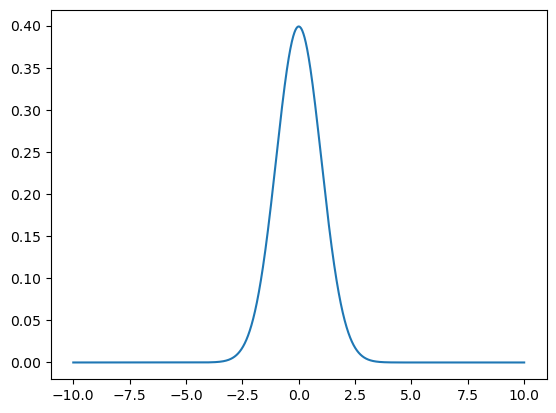

In [17]:
_ = plt.plot(x, pure_values)

# Computing $\pi$

We compute $\pi$ by throwing darts at a square and counting how many land in an inscribed circle.

## CPU implementation

In [18]:
@njit
def compute_pi_cpu(nr_tries):
    hits = 0
    for _ in range(nr_tries):
        x = random.random()
        y = random.random()
        if x**2 + y**2 < 1.0:
            hits += 1
    return 4.0*hits/nr_tries

In [19]:
compute_pi_cpu(100_000)

3.13992

## Precision

Just out of curiosity, what precision can we expect as a function of the number of darts?

In [20]:
def assess_precision(compute_pi, start_exp, stop_exp, nr_runs=5, *args):
    all_nr_tries = np.logspace(start_exp, stop_exp, num=stop_exp - start_exp + 1, dtype=np.int64)
    results = np.empty(shape=(all_nr_tries.size*nr_runs, 2))
    result_nr = 0
    for nr_tries in all_nr_tries:
        for _ in range(nr_runs):
            pi = compute_pi(nr_tries, *args)
            results[result_nr, :] = nr_tries, np.abs(pi - np.pi)/np.pi
            result_nr += 1
    return results

In [21]:
precisions = assess_precision(compute_pi_cpu, 2, 9, 5)

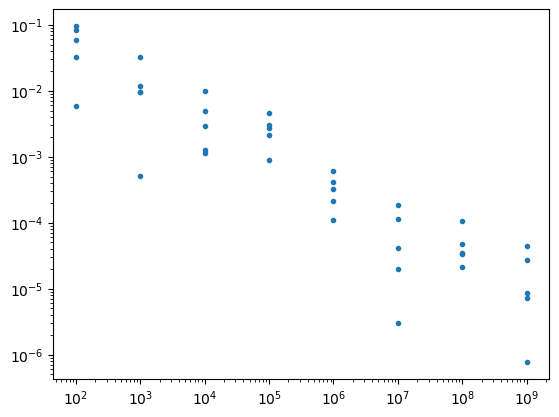

In [22]:
_ = plt.loglog(precisions[:, 0], precisions[:, 1], '.')

The precision increases, but not as fast as you might hope.

We want to compare the performance of the version that runs on CPU with the one on GPU, so we will define the number of tries in terms of number of blocks and number of threads per block, although that is not relevant for the CPU version.

In [23]:
nr_blocks = 4096
nr_threads_per_block = 128
nr_tries = 1024*nr_blocks*nr_threads_per_block

In [24]:
%timeit compute_pi_cpu(nr_tries)

14.9 s ± 242 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## GPU implementation

Since this requires a random number generator, we use the numba GPU random number generator `xoroshiro128p_uniform_float32`.

In [25]:
@cuda.jit
def compute_pi_kernel(rng_states, nr_tries, result):
    idx = cuda.grid(1)
    hits = 0
    for _ in range(nr_tries):
        x = xoroshiro128p_uniform_float32(rng_states, idx)
        y = xoroshiro128p_uniform_float32(rng_states, idx)
        if x**2 + y**2 < 1.0:
            hits += 1
    result[idx] = 4.0*hits/nr_tries

It would be useful to have a wrapper function, since some scaffolding is required to use this kernel.

In [26]:
def compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_blocks):
    rng_states = create_xoroshiro128p_states(nr_blocks*nr_threads_per_block,
                                             seed=random.randint(0, 100_000))
    dev_result = cuda.device_array((nr_blocks*nr_threads_per_block, ),
                                   dtype=np.float32)
    compute_pi_kernel[nr_blocks, nr_threads_per_block](
        rng_states,
        nr_tries//(nr_blocks*nr_threads_per_block),
        dev_result
    )
    cuda.synchronize()
    return np.sum(dev_result)/dev_result.shape[0]

In [27]:
compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_block)

np.float32(3.1415408)

In [28]:
%timeit compute_pi_gpu(nr_tries, nr_blocks, nr_threads_per_block)

108 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It is clear that the GPU version is significantly faster.

In [29]:
precisions = assess_precision(compute_pi_gpu, 2, 9, 5, nr_blocks, nr_threads_per_block)

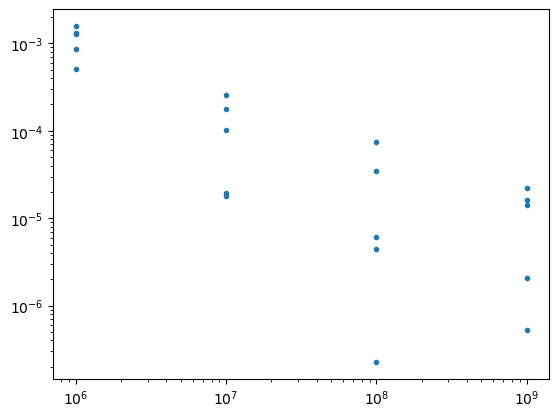

In [30]:
_ = plt.loglog(precisions[:, 0], precisions[:, 1], '.')

# Mandelbrot set

As for many of the other approeaches, we will consider the generation of the Mandelbrot set once more.

It can be easily implemented as a CUDA kernel using the numba library and specifying `cuda` as a target for the `vectorize` decorator.  We specify the signature of the function, using single precision copmlex numbers and unsigned 8-bit integers as return type.

In [31]:
@vectorize(['uint8(complex64, complex64, int32)'], target='cuda')
def mandelbrot(z, c, max_steps):
    nr_steps = 0
    while z.real**2 + z.imag**2 < 4.0 and nr_steps < max_steps:
        z = z**2 + c
        nr_steps += 1
    return nr_steps

Now we can generate the input complex numbers as a 2D array.

In [32]:
n = 1_000
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

Verify that the type of `z` is as expected, i.e., single precision complex.

In [33]:
z.dtype

dtype('complex64')

In [34]:
z.shape

(1000, 1000)

Define the other input values `c` and `max_steps`.

In [35]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

Do the computation on the device.

In [36]:
image = mandelbrot(z, c, max_steps)

The resulting data type is numpy array on the host, and its type is unsigned 8-bit as specified.

In [37]:
type(image)

numpy.ndarray

In [38]:
image.dtype

dtype('uint8')

In [39]:
image.shape

(1000, 1000)

We can visualize the result using matplotlib.

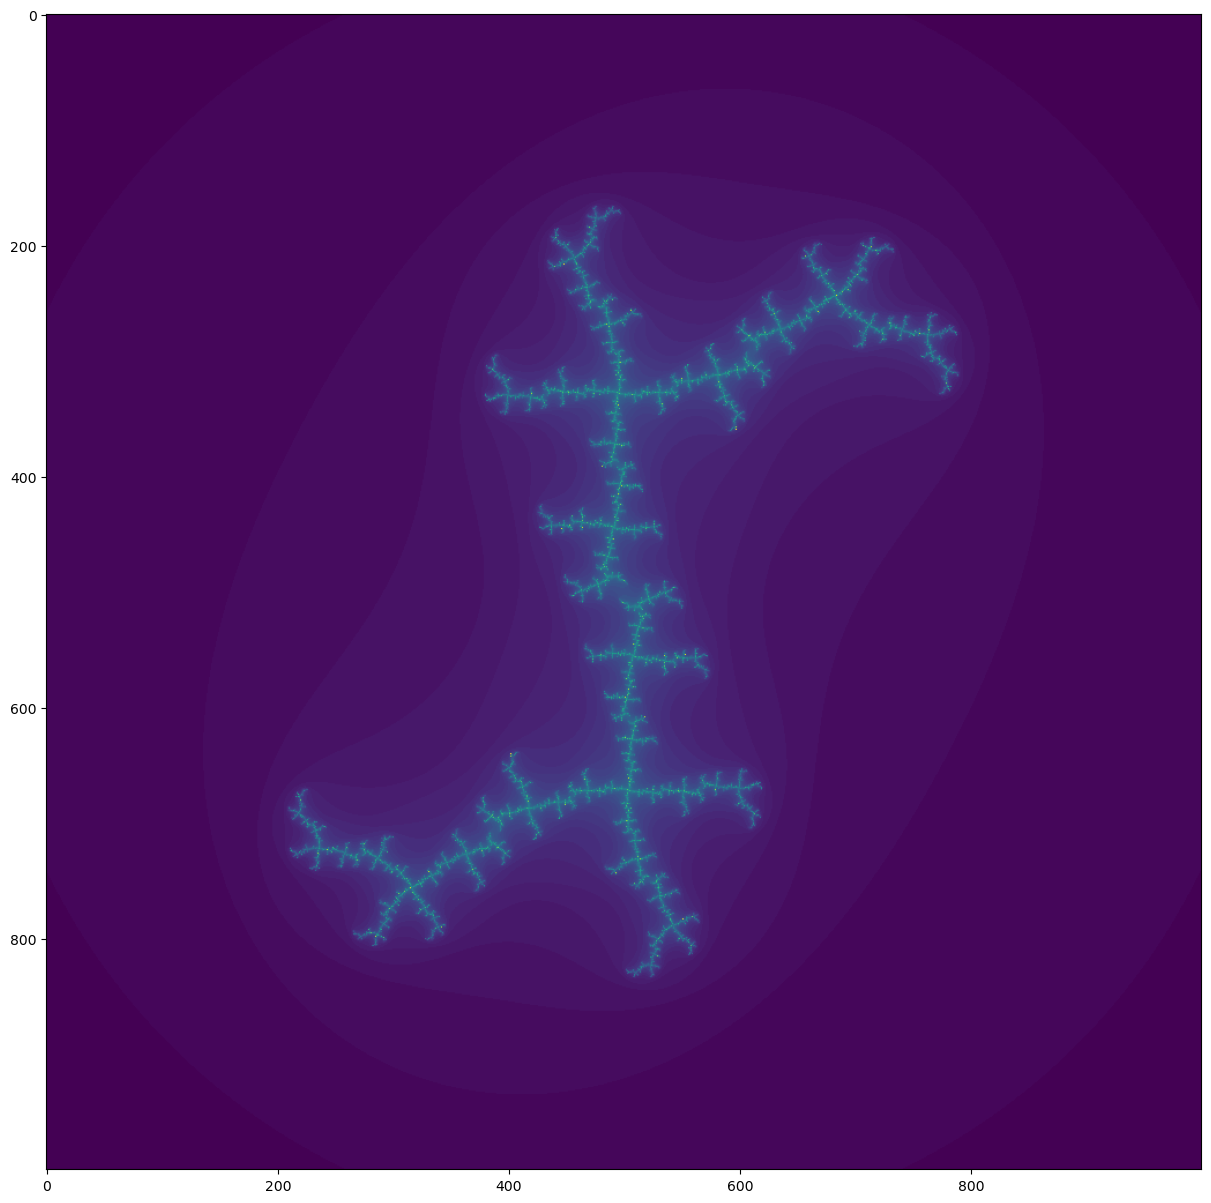

In [40]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(image)

Compared to pyCUDA, using numba is considerably easier.

## Benchmarks

Let's compare the performance of numba on CPU and GPU.

In [41]:
@vectorize(['uint8(complex64, complex64, int32)'])
def mandelbrot_cpu(z, c, max_steps):
    nr_steps = 0
    while z.real**2 + z.imag**2 < 4.0 and nr_steps < max_steps:
        z = z**2 + c
        nr_steps += 1
    return nr_steps

In [42]:
@vectorize(['uint8(complex64, complex64, int32)'], target='cuda')
def mandelbrot_gpu(z, c, max_steps):
    nr_steps = np.uint8(0)
    while z.real*z.real + z.imag*z.imag < 4.0 and nr_steps < max_steps:
        z = z*z + c
        nr_steps += 1
    return nr_steps

In [43]:
n = 10_000
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

In [44]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

In [45]:
%timeit mandelbrot_cpu(z, c, max_steps)

684 ms ± 11.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
%timeit mandelbrot_gpu(z, c, max_steps)

708 ms ± 98.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
z_dev = cuda.to_device(z)
image = cuda.device_array(shape=z.shape, dtype=np.uint8)

In [48]:
%timeit mandelbrot_gpu(z_dev, c, max_steps, out=image)

465 ms ± 59.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


However, the performance is not particularly impressive.

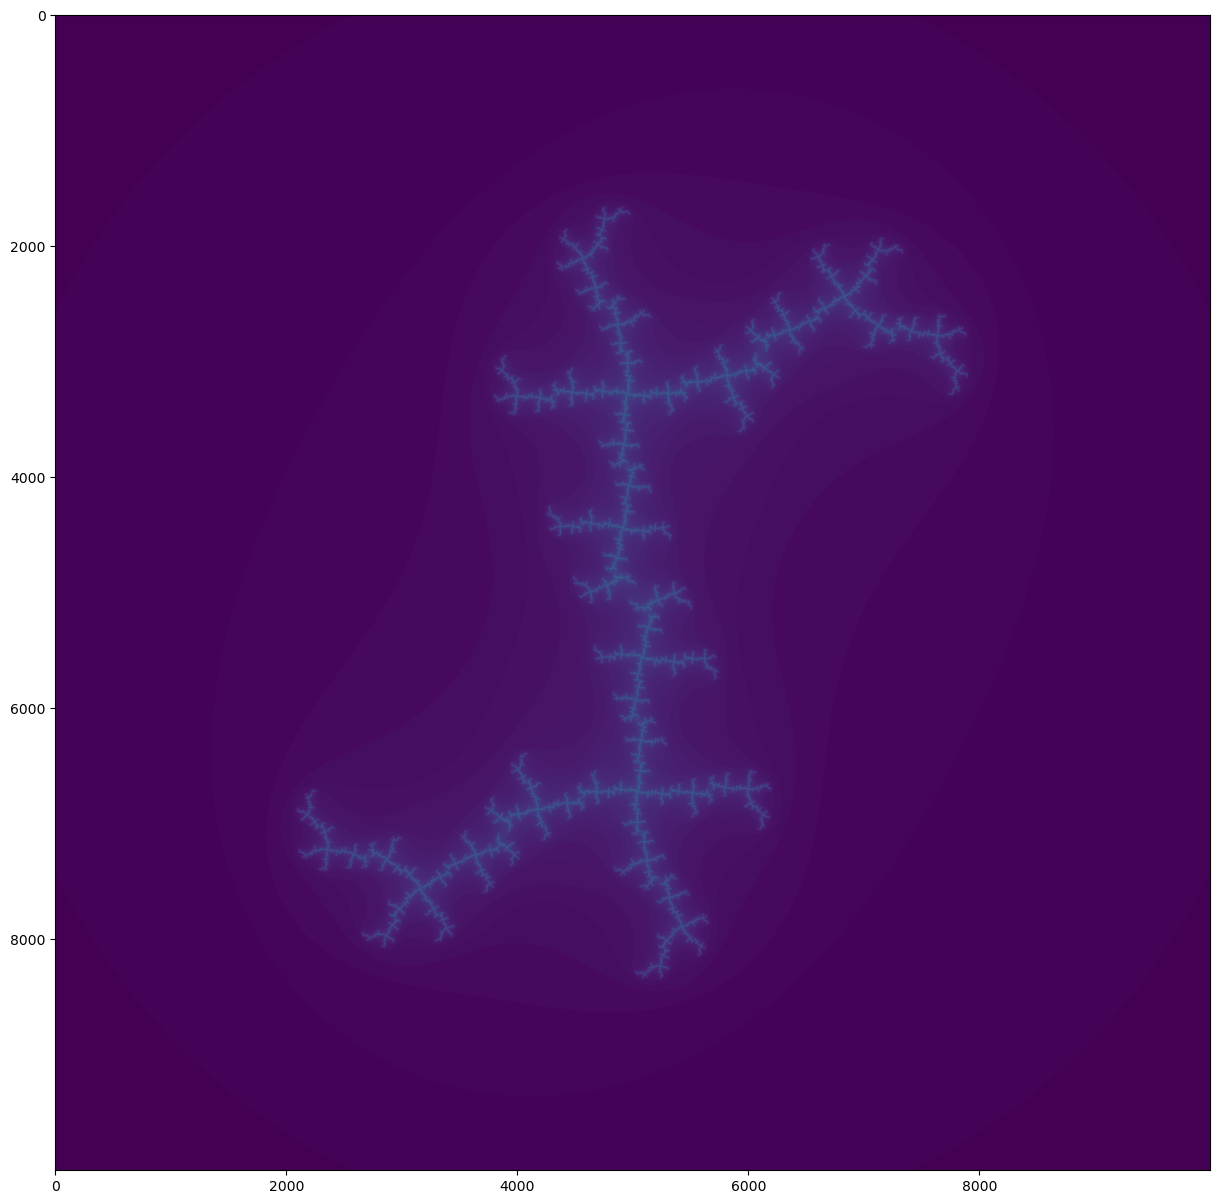

In [49]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(image.copy_to_host())

## Grid stride loops

In [50]:
@cuda.jit
def mandelbrot_kernel(Z, c, max_steps, nr_steps):
    x, y = cuda.grid(2)
    x_stride, y_stride = cuda.gridsize(2)
    for i in range(x, Z.shape[0], x_stride):
        for j in range(y, Z.shape[1], y_stride):
            nr_steps[i][j] = 0
            z = Z[i][j]
            while (z.real*z.real + z.imag*z.imag < np.float32(4.0) and
                   nr_steps[i][j] < max_steps):
                z = z*z + c
                nr_steps[i][j] += 1

In [92]:
nr_blocks_per_dim = 256
nr_bolcks = nr_blocks_per_dim**2
nr_threads_per_dim = 16
nr_threads_per_block = nr_threads_per_dim**2

In [93]:
n = nr_blocks_per_dim*nr_threads_per_dim
x = np.linspace(-1.8, 1.8, n, dtype=np.float32)
y = np.linspace(-1.8, 1.8, n, dtype=np.float32)
X, Y = np.meshgrid(x, y)
z = X + 1.0j*Y

In [94]:
n

4096

In [95]:
c = np.complex64(0.4 + 0.6j)
max_steps = np.int32(256)

In [96]:
dev_z = cuda.to_device(z)
result = np.zeros(z.shape, dtype=np.uint8)
dev_result = cuda.to_device(result)

In [100]:
mandelbrot_kernel[(nr_blocks_per_dim, nr_blocks_per_dim), (nr_threads_per_dim, nr_threads_per_dim)](dev_z, c, max_steps,
                                                   dev_result)

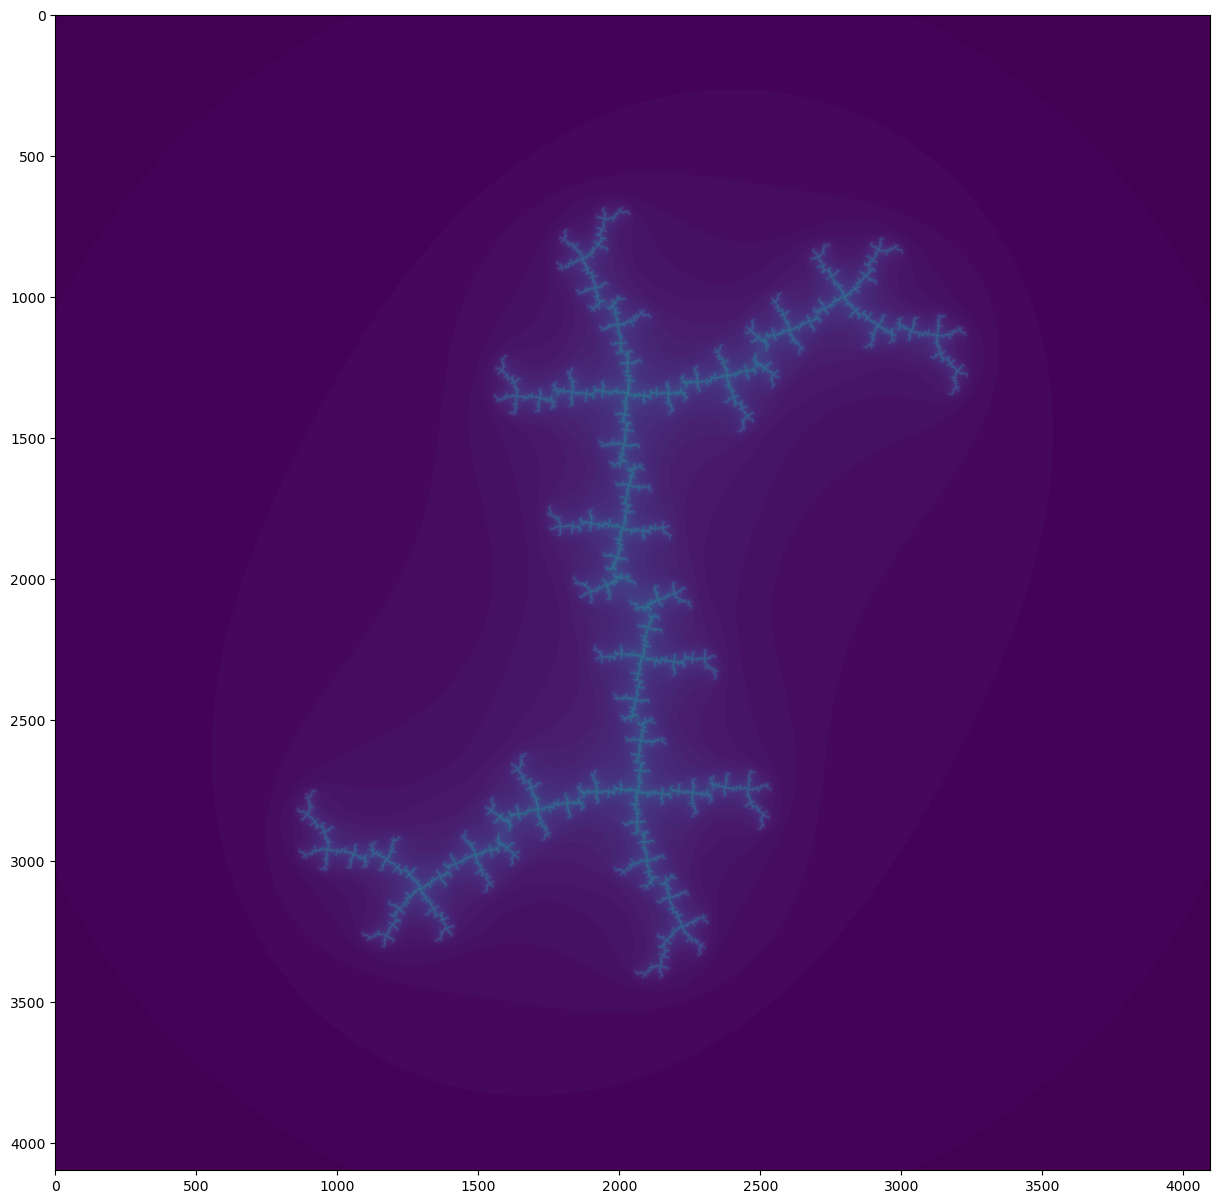

In [101]:
figure, axes = plt.subplots(figsize=(15, 15))
axes.set_aspect('equal')
_ = axes.imshow(dev_result.copy_to_host())

In [102]:
%timeit mandelbrot_kernel[(nr_blocks_per_dim, nr_blocks_per_dim), (nr_threads_per_dim, nr_threads_per_dim)](dev_z, c, max_steps, dev_result); cuda.synchronize()

1.46 ms ± 35.6 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [103]:
%timeit mandelbrot_cpu(z, c, max_steps)

114 ms ± 336 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Giving threads more work improves the performance by a factor of 15.

## Coalescing memory

However, the memory access pattern is suboptimal.  It can be improved by ensuring that the threads in a warp use data that is on the same cache line.  The 2D array $z$ is stored row-wise, so  the 32 threads will use 32 consecutive values when the array is traversed if the row index changes faster.  This memory access pattern is called coalesced in GPU-speak.

In [104]:
@cuda.jit
def mandelbrot_coalesced_kernel(Z, c, max_steps, nr_steps):
    x, y = cuda.grid(2)
    x_stride, y_stride = cuda.gridsize(2)
    for i in range(x, Z.shape[0], x_stride):
        for j in range(y, Z.shape[1], y_stride):
            nr_steps[j][i] = 0
            z = Z[j][i]
            steps = 0
            while (z.real*z.real + z.imag*z.imag < np.float32(4.0) and
                   steps < max_steps):
                z = z*z + c
                steps += 1
            nr_steps[j][i] = min(steps, max_steps - 1)

In [105]:
%timeit mandelbrot_coalesced_kernel[(nr_blocks_per_dim, nr_blocks_per_dim), (nr_threads_per_dim, nr_threads_per_dim)](dev_z, c, max_steps, dev_result); cuda.synchronize()

891 μs ± 14.4 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Thanks to coalesced memory access, the performance is again improved.

# Data mapping

We can explore the mapping of data on blocks by assigning the block index to an array element.

In [62]:
@cuda.jit
def map_2d_kernel(A):
    idx = cuda.grid(1)
    x, y = cuda.grid(2)
    A[x, y] = idx

In [63]:
A = np.zeros((16, 16), dtype=np.int32)
nr_blocks = (1, 1)
nr_threads_per_block = (16, 16)

In [64]:
map_2d_kernel[nr_blocks, nr_threads_per_block](A)

/home/gjb/mambaforge/envs/python_on_gpus_numba/lib/python3.12/site-packages/numba_cuda/numba/cuda/dispatcher.py:696: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(errors.NumbaPerformanceWarning(msg))
/home/gjb/mambaforge/envs/python_on_gpus_numba/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:934: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [65]:
A

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,

# Row versus column sum and memory access

In [66]:
n = 2**14
nr_threads_per_block = 128
nr_blocks = n//nr_threads_per_block

In [67]:
nr_blocks

128

In [68]:
A = np.random.uniform(size=(n, n)).astype(np.float32)
A_dev = cuda.to_device(A)
sums = np.zeros((n, ), dtype=np.float32)
sums_dev = cuda.to_device(sums)

In [69]:
@cuda.jit
def row_sum_kernel(A, sums):
    idx = cuda.grid(1)
    row_sum = 0.0
    for j in range(A.shape[1]):
        row_sum += A[idx][j]
    sums[idx] = row_sum

In [70]:
row_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev)

In [71]:
cuda.synchronize()

In [72]:
sums_dev.copy_to_host()

array([8177.824 , 8140.8037, 8185.052 , ..., 8175.3955, 8205.997 ,
       8197.537 ], shape=(16384,), dtype=float32)

In [73]:
%timeit row_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev); cuda.synchronize()

10.4 ms ± 56.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
@cuda.jit
def col_sum_kernel(A, sums):
    idx = cuda.grid(1)
    col_sum = 0.0
    for i in range(A.shape[0]):
        col_sum += A[i][idx]
    sums[idx] = col_sum

In [75]:
col_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev)

In [76]:
sums_dev.copy_to_host()

array([8146.099 , 8183.0356, 8206.059 , ..., 8191.9688, 8243.057 ,
       8146.758 ], shape=(16384,), dtype=float32)

In [77]:
%timeit col_sum_kernel[nr_blocks, nr_threads_per_block](A_dev, sums_dev); cuda.synchronize()

6.6 ms ± 25.8 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Device functions

Device functions can be easily defined using the optional `device` argument in the decorator.  Such functions can only be called from kernels or other device functions, never from the host.

In [78]:
@cuda.jit(device=True)
def distance_dev(a, b):
    return math.sqrt(a**2 + b**2)

In [79]:
candidates = np.array(list(itertools.permutations(range(1, 10))),
                      dtype=np.int64)

In [80]:
nr_threads_per_block = 128
n = 10_000*nr_threads_per_block
a = np.random.uniform(size=n).astype(np.float32)
b = np.random.uniform(size=n).astype(np.float32)
expected = np.sqrt(a**2 + b**2)
out = np.empty_like(a)

In [81]:
@cuda.jit
def distance_kernel(a, b, out):
    start = cuda.grid(1)
    stride = cuda.gridsize(1)
    for i in range(start, a.shape[0], stride):
        out[i] = distance_dev(a[i], b[i])

In [82]:
distance_kernel[nr_blocks, nr_threads_per_block](a, b, out)

/home/gjb/mambaforge/envs/python_on_gpus_numba/lib/python3.12/site-packages/numba_cuda/numba/cuda/cudadrv/devicearray.py:934: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


In [83]:
np.testing.assert_almost_equal(out, expected)